In [80]:
import csv
import json
import os
import os.path
import pickle as pkl
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchutils
from tqdm.auto import tqdm


In [81]:
def load_json(fn):
    with open(fn, "r") as f:
        data = json.load(f)
    return data

In [82]:
inputDir = "release"
outputDir = "processed"
dataSet = "nondisjoint"
# dataSet = "disjoint"
saveFile = True

In [83]:
# all imgages saved in item_id.jpg format
image_files = torchutils.files.scan_files(f"{inputDir}/images", suffix="jpg")
print("Nubmer of images: {:,}".format(len(image_files)))

Nubmer of images: 261,057


## Example item format
```json
{'category_id': '29',
 'catgeories': ["Women's Fashion", 'Clothing', 'Shorts'],
 'description': 'Blue High Waist Plain Polyester Loose Button Fly Street '
                'Shorts, Size Available: S,M,L,XL S, M, L, XL Plain Blue '
                'Polyester Style: Street.',
 'related': ['High waisted jean shorts',
             'High-waisted denim shorts',
             'Blue shorts',
             'High-rise shorts',
             'Highwaist shorts',
             'Button shorts'],
 'semantic_category': 'bottoms',
 'title': 'Blue High Waist Buttons Denim Shorts',
 'url_name': 'blue high waist buttons denim'}
```

In [84]:
metaData = torchutils.io.load_json(f"{inputDir}/polyvore_item_metadata.json")


# item id to item semantic category
itemType = {}

# fine grained categories to semantic category
fineGrained2Semantic = dict()

# set of all semantic categories
semanticSet = set()
for k, v in metaData.items():
    semanticSet.add(v["semantic_category"])
    fineGrained2Semantic[v["category_id"]] = v["semantic_category"]
    itemType[k] = v["semantic_category"]


# smenatic category to index id
semanticDict = dict()
for cate in sorted(semanticSet):
    semanticDict[cate] = len(semanticDict)

print("Number of items: {:,}".format(len(metaData)))
print("Number of fine-grained categories: {:,}".format(len(fineGrained2Semantic)))
print("Number of semantic categories: {:,}".format(len(semanticDict)))

print("{:=^30}".format(" Semantic category to index "))
pprint(semanticDict)


Number of items: 251,008
Number of fine-grained categories: 153
Number of semantic categories: 11
= Semantic category to index =
{'accessories': 0,
 'all-body': 1,
 'bags': 2,
 'bottoms': 3,
 'hats': 4,
 'jewellery': 5,
 'outerwear': 6,
 'scarves': 7,
 'shoes': 8,
 'sunglasses': 9,
 'tops': 10}


# Reformat the outfit tuples


In [85]:
src_dir = os.path.join(inputDir, dataSet)
dst_dir = os.path.join(outputDir, dataSet)

if not os.path.exists(dst_dir):
    os.mkdir(dst_dir)

with open(f"{inputDir}/{dataSet}/typespaces.p", "rb") as f:
    types = pkl.load(f)

print("Number of conditions:", len(types))
data = [[i, j, "+"] for i, j in (types)]
df = pd.DataFrame(data)

df.pivot(index=0, columns=1, values=2)

Number of conditions: 66


1,accessories,all-body,bags,bottoms,hats,jewellery,outerwear,scarves,shoes,sunglasses,tops
0,,,,,,,,,,,
accessories,+,+,NaN,+,NaN,NaN,+,+,NaN,+,NaN
all-body,NaN,+,NaN,+,NaN,NaN,+,+,NaN,NaN,NaN
bags,+,+,+,+,+,+,+,+,+,+,+
bottoms,NaN,NaN,NaN,+,NaN,NaN,+,+,NaN,NaN,NaN
hats,+,+,NaN,+,+,NaN,+,+,NaN,+,+
jewellery,+,+,NaN,+,+,+,+,+,NaN,+,+
outerwear,NaN,NaN,NaN,NaN,NaN,NaN,+,NaN,NaN,NaN,NaN
scarves,NaN,NaN,NaN,NaN,NaN,NaN,+,+,NaN,NaN,NaN
shoes,+,+,NaN,+,+,+,+,+,+,+,+


In [86]:
trainOutfits = torchutils.io.load_json(os.path.join(src_dir, "train.json"))
validOutfits = torchutils.io.load_json(os.path.join(src_dir, "valid.json"))
testOutfits = torchutils.io.load_json(os.path.join(src_dir, "test.json"))

allOutfits = trainOutfits + validOutfits + testOutfits
outfit = np.random.choice(allOutfits)
print(
    "Number of {} outfits: {:,} = train ({:,}) + valid({:,}) + test({:,})".format(
        dataSet, len(allOutfits), len(trainOutfits), len(validOutfits), len(testOutfits)
    )
)
print("Example outfit")
pprint(outfit)

MAX_SIZE = 0
for outfit in allOutfits:
    MAX_SIZE = max(MAX_SIZE, len(outfit["items"]))
print("Number of items (max): {}".format(MAX_SIZE))


Number of nondisjoint outfits: 68,306 = train (53,306) + valid(5,000) + test(10,000)
Example outfit
{'items': [{'index': 1, 'item_id': '213206865'},
           {'index': 2, 'item_id': '146801579'},
           {'index': 3, 'item_id': '182659247'},
           {'index': 4, 'item_id': '215081136'},
           {'index': 5, 'item_id': '117701427'},
           {'index': 6, 'item_id': '193384411'},
           {'index': 7, 'item_id': '127632069'},
           {'index': 8, 'item_id': '129434210'}],
 'set_id': '225320884'}
Number of items (max): 19


In [87]:
# create item list
itemList = [set() for _ in range(len(semanticSet))]

for outfit in allOutfits:
    items = outfit["items"]
    for item in outfit["items"]:
        item_id = item["item_id"]
        item_type = itemType[item_id]
        type_id = semanticDict[item_type]
        itemList[type_id].add(item_id)

# itemList = [sorted(list(items)) for items in itemList]
itemList = [list(items) for items in itemList]
itemIndex = []
for items in itemList:
    itemIndex.append({key: index for index, key in enumerate(items)})
print(list(map(len, itemList)))

if saveFile:
    torchutils.io.save_json(f"{dst_dir}/items.json", itemList)


[6973, 18478, 40717, 27670, 6071, 41414, 17065, 4898, 44850, 9874, 32998]


In [88]:
def count_items(outfits):
    sizes = [len(o["items"]) for o in outfits]
    return sizes


def count_conditions(outfits):
    conditions = set()
    for outfit in outfits:
        items = outfit["items"]
        size = len(items)
        for i in range(size):
            for j in range(size):
                id_i = items[i]["item_id"]
                id_j = items[j]["item_id"]
                if (itemType[id_i], itemType[id_j]) in conditions:
                    continue
                if (itemType[id_j], itemType[id_i]) in conditions:
                    continue
                conditions.add((itemType[id_i], itemType[id_j]))
    return conditions



Number conditions: 66


1,accessories,all-body,bags,bottoms,hats,jewellery,outerwear,scarves,shoes,sunglasses,tops
0,,,,,,,,,,,
accessories,+,+,NaN,+,NaN,NaN,+,+,NaN,+,NaN
all-body,NaN,+,NaN,+,NaN,NaN,+,+,NaN,NaN,NaN
bags,+,+,+,+,+,+,+,+,+,+,+
bottoms,NaN,NaN,NaN,+,NaN,NaN,+,+,NaN,NaN,NaN
hats,+,+,NaN,+,+,NaN,+,+,NaN,+,+
jewellery,+,+,NaN,+,+,+,+,+,NaN,+,+
outerwear,NaN,NaN,NaN,NaN,NaN,NaN,+,NaN,NaN,NaN,NaN
scarves,NaN,NaN,NaN,NaN,NaN,NaN,+,+,NaN,NaN,NaN
shoes,+,+,NaN,+,+,+,+,+,+,+,+


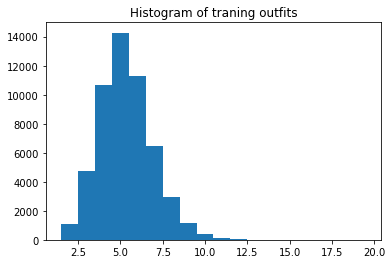

In [89]:
plt.hist(count_items(trainOutfits), bins=np.arange(MAX_SIZE) + 1.5)
plt.title("Histogram of traning outfits")
train_conditions = count_conditions(trainOutfits)
print("Number conditions: %d" % len(train_conditions))

data = [[i, j, "+"] for i, j in (types)]
df = pd.DataFrame(data)

df.pivot(index=0, columns=1, values=2)


Number conditions: 66


1,accessories,all-body,bags,bottoms,hats,jewellery,outerwear,scarves,shoes,sunglasses,tops
0,,,,,,,,,,,
accessories,+,+,NaN,+,NaN,NaN,+,+,NaN,+,NaN
all-body,NaN,+,NaN,+,NaN,NaN,+,+,NaN,NaN,NaN
bags,+,+,+,+,+,+,+,+,+,+,+
bottoms,NaN,NaN,NaN,+,NaN,NaN,+,+,NaN,NaN,NaN
hats,+,+,NaN,+,+,NaN,+,+,NaN,+,+
jewellery,+,+,NaN,+,+,+,+,+,NaN,+,+
outerwear,NaN,NaN,NaN,NaN,NaN,NaN,+,NaN,NaN,NaN,NaN
scarves,NaN,NaN,NaN,NaN,NaN,NaN,+,+,NaN,NaN,NaN
shoes,+,+,NaN,+,+,+,+,+,+,+,+


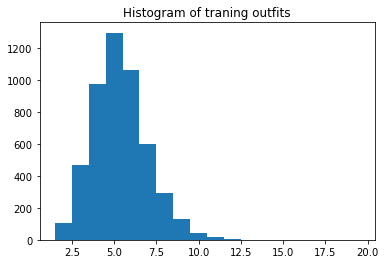

In [90]:
plt.hist(count_items(validOutfits), bins=np.arange(MAX_SIZE) + 1.5)
plt.title("Histogram of traning outfits")
valid_conditions = count_conditions(validOutfits)
print("Number conditions: %d" % len(valid_conditions))
data = [[i, j, "+"] for i, j in (types)]
df = pd.DataFrame(data)

df.pivot(index=0, columns=1, values=2)


Number conditions: 66


1,accessories,all-body,bags,bottoms,hats,jewellery,outerwear,scarves,shoes,sunglasses,tops
0,,,,,,,,,,,
accessories,+,+,NaN,+,NaN,NaN,+,+,NaN,+,NaN
all-body,NaN,+,NaN,+,NaN,NaN,+,+,NaN,NaN,NaN
bags,+,+,+,+,+,+,+,+,+,+,+
bottoms,NaN,NaN,NaN,+,NaN,NaN,+,+,NaN,NaN,NaN
hats,+,+,NaN,+,+,NaN,+,+,NaN,+,+
jewellery,+,+,NaN,+,+,+,+,+,NaN,+,+
outerwear,NaN,NaN,NaN,NaN,NaN,NaN,+,NaN,NaN,NaN,NaN
scarves,NaN,NaN,NaN,NaN,NaN,NaN,+,+,NaN,NaN,NaN
shoes,+,+,NaN,+,+,+,+,+,+,+,+


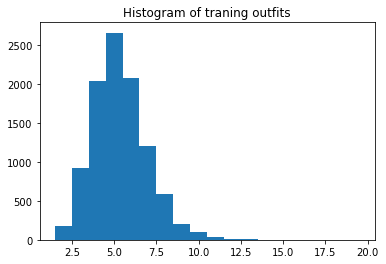

In [91]:
plt.hist(count_items(testOutfits), bins=np.arange(MAX_SIZE) + 1.5)
plt.title("Histogram of traning outfits")
test_conditions = count_conditions(testOutfits)
print("Number conditions: %d" % len(test_conditions))
data = [[i, j, "+"] for i, j in (types)]
df = pd.DataFrame(data)
df.pivot(index=0, columns=1, values=2)


In [92]:
def convert_tuples(outfits, max_size):
    tuples = []
    for outfit in outfits:
        items = outfit["items"]
        size = len(items)
        m = max_size - size
        item_ids = [i["item_id"] for i in items]
        types = [semanticDict[itemType[i]] for i in item_ids]
        items = [itemIndex[c][i] for c, i in zip(types, item_ids)]
        tuples.append([0, size] + items + [-1] * m + types + [-1] * m)
    return np.array(tuples)


In [93]:
trainTuples = convert_tuples(trainOutfits, MAX_SIZE)
validTuples = convert_tuples(validOutfits, MAX_SIZE)
testTuples = convert_tuples(testOutfits, MAX_SIZE)


In [94]:
with open(os.path.join(dst_dir, "train_pos"), "w") as f:
    writer = csv.writer(f)
    writer.writerows(trainTuples)

with open(os.path.join(dst_dir, "valid_pos"), "w") as f:
    writer = csv.writer(f)
    writer.writerows(validTuples)

with open(os.path.join(dst_dir, "test_pos"), "w") as f:
    writer = csv.writer(f)
    writer.writerows(testTuples)


In [95]:
name2Id = dict()
itemSet = set()
# since all items saved in item_id format, we do not need to check the content
for outfit in allOutfits:
    set_id = outfit["set_id"]
    for item in outfit["items"]:
        item_id = item["item_id"]
        index = item["index"]
        name = "{}_{}".format(set_id, index)
        name2Id[name] = item_id
        itemSet.add(item_id)
print("Number of items: {}, unique items: {}".format(len(name2Id), len(itemSet)))


Number of items: 365054, unique items: 251008


In [96]:
def compatibility(fn):
    pos_tuples = []
    neg_tuples = []
    with open(fn) as f:
        lines = f.readlines()
    for line in lines:
        label, *outfit = line.split()
        tpl = [-1] * (2 * MAX_SIZE)
        for n, item in enumerate(outfit):
            item_id = name2Id[item]
            item_type = semanticDict[itemType[item_id]]
            tpl[n] = itemIndex[item_type][item_id]
            tpl[n + MAX_SIZE] = item_type
        tpl = [0, len(outfit)] + tpl
        if int(label) == 1:
            pos_tuples.append(tpl)
        else:
            neg_tuples.append(tpl)
    return np.array(pos_tuples), np.array(neg_tuples)



In [97]:
splits = ["train", "valid", "test"]
outfits = dict(train=trainTuples, valid=validTuples, test=testTuples)
save = True
for phase in splits:
    compatibility_fn = os.path.join(src_dir, "compatibility_{}.txt".format(phase))
    pos_tuples, neg_tuples = compatibility(compatibility_fn)
    assert (pos_tuples == outfits[phase]).all()
    # save negative outfits into files
    print(f"Number of {phase} positive outfits: {len(pos_tuples):,}")
    print(f"Number of {phase} negative outfits: {len(neg_tuples):,}")
    if save:
        torchutils.io.save_csv(f"{dst_dir}/{phase}_neg", neg_tuples)


Number of train positive outfits: 53,306
Number of train negative outfits: 53,306
Number of valid positive outfits: 5,000
Number of valid negative outfits: 5,000
Number of test positive outfits: 10,000
Number of test negative outfits: 10,000


In [98]:
pos_set = {
    "train": set(map(tuple, trainTuples)),
    "valid": set(map(tuple, validTuples)),
    "test": set(map(tuple, testTuples)),
}


"""Example of a question
{
    "question": ["222049137_1", "222049137_2", "222049137_3", "222049137_4", "222049137_5"], 
    "blank_position": 6, 
    "answers": ["136139735_5", "171518178_4", "191247707_5", "222049137_6"]
}
"""


def convert_fitb(phase, one_tuple=False):
    pos_data = []
    neg_data = []
    positive_set = pos_set[phase]
    fn = os.path.join(src_dir, "fill_in_blank_{}.json".format(phase))
    with open(fn) as f:
        data = json.load(f)
    tuples = []
    for d in tqdm(data):
        position = d["blank_position"]
        question = d["question"]
        set_id = question[0].split("_")[0]
        question_ids = [name2Id[i] for i in question]
        question_types = [semanticDict[itemType[i]] for i in question_ids]
        question_items = [itemIndex[c][i] for c, i in zip(question_types, question_ids)]
        n = len(question) + 1
        m = MAX_SIZE - n
        one_question = []
        for ans in d["answers"]:
            items = question_items.copy()
            types = question_types.copy()
            ans_id = name2Id[ans]
            ans_type = semanticDict[itemType[ans_id]]
            ans_item = itemIndex[ans_type][ans_id]
            items.insert(position - 1, ans_item)
            types.insert(position - 1, ans_type)
            ques_tpl = [0, n] + items + [-1] * m + types + [-1] * m
            if ans.split("_")[0] == set_id:
            # if tuple(ques_tpl) in positive_set:[]
                # true answer
                pos_data.append(ques_tpl)
                one_question.insert(0, ques_tpl)
            else:
                # false answer
                neg_data.append(ques_tpl)
                one_question.append(ques_tpl)
        tuples += one_question
    tuples = np.array(tuples)
    pos_data = np.array(pos_data)
    neg_data = np.array(neg_data)
    if one_tuple:
        return tuples
    return pos_data, neg_data


In [99]:
splits = ["train", "valid", "test"]
for phase in splits:
    pos, neg = convert_fitb(phase)
    print(f"Number of {phase} questions: {len(neg) // len(pos) + 1}")
    torchutils.io.save_csv(f"{dst_dir}/{phase}_pos_fitb", pos)
    torchutils.io.save_csv(f"{dst_dir}/{phase}_neg_fitb", neg)
    # tuples = convert_fitb(phase)
    # print(f"Number of {phase} questions: {len(tuples) // 4}")
    # torchutils.io.save_csv(f"{dst_dir}/{phase}_fitb", tuples)



  0%|          | 0/53306 [00:00<?, ?it/s]

Number of train questions: 4


  0%|          | 0/5000 [00:00<?, ?it/s]

Number of valid questions: 4


  0%|          | 0/10000 [00:00<?, ?it/s]

Number of test questions: 4
